In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt

2023-04-24 17:05:52.985152: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 17:05:52.986704: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 17:05:53.017250: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 17:05:53.017838: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 17:05:53.577679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# Define the function to load our dataset files
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Load and preprocess the dataset
def load_cifar10_data(data_dir):
    train_data = None
    train_labels = []

    for i in range(1, 6):
        data_dict = unpickle(os.path.join(data_dir, f'data_batch_{i}'))
        if i == 1:
            train_data = data_dict[b'data']
        else:
            train_data = np.vstack((train_data, data_dict[b'data']))
        train_labels += data_dict[b'labels']

    test_data_dict = unpickle(os.path.join(data_dir, 'test_batch'))
    test_data = test_data_dict[b'data']
    test_labels = test_data_dict[b'labels']

    train_data = train_data.reshape((len(train_data), 3, 32, 32))
    train_data = np.rollaxis(train_data, 1, 4)
    train_labels = np.array(train_labels)

    test_data = test_data.reshape((len(test_data), 3, 32, 32))
    test_data = np.rollaxis(test_data, 1, 4)
    test_labels = np.array(test_labels)

    return train_data, train_labels, test_data, test_labels


data_dir = './cifar-10-batches-py'
x_train, y_train, x_test, y_test = load_cifar10_data(data_dir)

# Preprocess input data, and normalize the input data 
x_train = x_train / 255.0
x_test = x_test / 255.0

chosen_category = 0

# Convert class labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)


In [3]:
# Function to plot validation loss
def plot_validation_loss(history):
    plt.plot(history.history['val_loss'])
    plt.title('Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Validation'], loc='upper right')
    plt.show()

In [4]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)

# Add the final output layer for 10-class classification
# predictions = Dense(10, activation='softmax')(x)
predictions = Dense(10, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)


2023-04-24 17:05:55.957588: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [5]:
# Fine-tune only the top layers (freeze all convolutional layers)
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Training the model
history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))


Epoch 1/5
1563/1563 [==============================] - 179s 114ms/step - loss: 1.4983 - accuracy: 0.4908 - val_loss: 1.3314 - val_accuracy: 0.5412
Epoch 2/5
1563/1563 [==============================] - 181s 116ms/step - loss: 1.2591 - accuracy: 0.5673 - val_loss: 1.2519 - val_accuracy: 0.5625
Epoch 3/5
1563/1563 [==============================] - 181s 116ms/step - loss: 1.1943 - accuracy: 0.5874 - val_loss: 1.2137 - val_accuracy: 0.5774
Epoch 4/5
1563/1563 [==============================] - 181s 116ms/step - loss: 1.1570 - accuracy: 0.6012 - val_loss: 1.1996 - val_accuracy: 0.5811
Epoch 5/5
1563/1563 [==============================] - 182s 116ms/step - loss: 1.1272 - accuracy: 0.6115 - val_loss: 1.1810 - val_accuracy: 0.5861


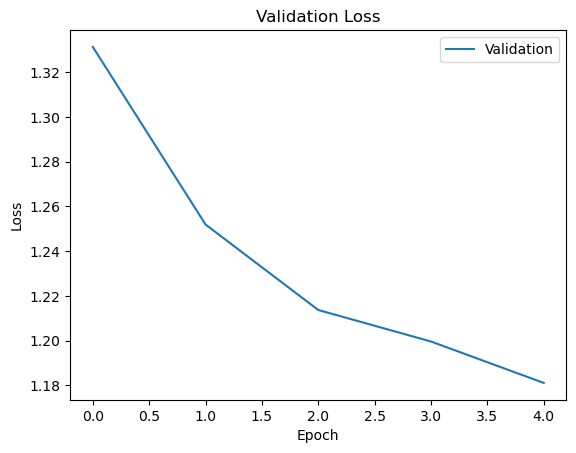

In [6]:
# Plotting the validation loss
plot_validation_loss(history)

In [7]:

# Load a new image and preprocess it
new_image_path = './new_images/picture_1.png'# Here is the pathing for the image so if you want to add an image just past it into this folder and change the name.
new_image = image.load_img(new_image_path, target_size=(32, 32))
new_image = image.img_to_array(new_image)
new_image = np.expand_dims(new_image, axis=0)
new_image = new_image / 255.0

# Predict the class of the new image
prediction = model.predict(new_image)
predicted_class = 1 if prediction[0][0] > 0.5 else 0

# Get the class with the highest probability
# predicted_class = np.argmax(prediction)

# Print the prediction result
# categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# print(f"The image is predicted to be a {categories[predicted_class]}.")


categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
if predicted_class:
    print(f"The image is predicted to be an {categories[chosen_category]}.")
else:
    print(f"The image is predicted to not be an {categories[chosen_category]}.")



1/1 [==============================] - 0s 113ms/step
The image is predicted to be an airplane.
